# 1. KITTI 데이터셋 확인

자율주행 보조장치는 카메라에 사람이 가까워졌을 때, 그리고 차가 가까워져서 탐지된 크기가 일정 이상일 때 멈춰야 합니다.  

> *자율주행 보조장치 object detection 조건* 
> - 1) 사람이 카메라에 감지되면 정지
> - 2) 차량이 일정 크기 이상으로 감지되면 정지



KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D objecte detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있습니다.


먼저 필요한 라이브러리를 불러 오겠습니다.  

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [5]:


# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

다운로드한 KITTI 데이터셋을 `tfds.show_examples`를 통해 보면, 우리의 시ㅏ각보다 더 다양한 각도를 물체가 촬용이 되어 있습니다.



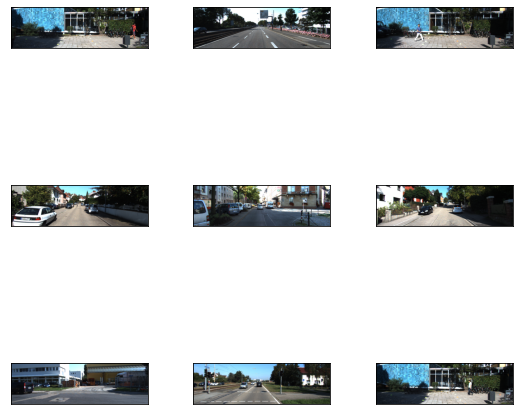

In [6]:
fig = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 `ds_info`에서는 불러온 데이터셋의 정보를 확인할 수 있습니다.

오늘 사용할 데이터셋은 7,481개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있습니다.

라벨에는 `alpha`, `bbox`, `dimensions`, `location`, `occluded`, `rotation_y`, `truncated` 등의 정보가 있습니다.

In [7]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel-dj40/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
    

## 데이터 직접 확인하기

*첫 실습 때 하지 않은 부분


이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠습니다. `ds_train.take(1)`을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 `TakeDataset`을 얻을 수 있습니다.

이렇게 뽑은 데이터에는 `image` 등의 정보가 포함되어 있습니다.  

눈으로 확인해서 학습에 사용할 데이터를 직접 이해할 수 있게 됩니다.

In [9]:
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(6,), dtype=float32, numpy=array([ 2.26,  1.79,  1.69,  1.66, -2.03,  1.66], dtype=float32)>, 'bbox': <tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0.00266667, 0.        , 0.43826666, 0.20758455],
       [0.34125334, 0.32380033, 0.50850666, 0.39439613],
       [0.39024   , 0.368752  , 0.58568   , 0.4270612 ],
       [0.36549333, 0.41580516, 0.51453334, 0.47304347],
       [0.25906667, 0.72520936, 0.59816   , 0.8084863 ],
       [0.45048   , 0.418905  , 0.5186933 , 0.4433092 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1.37, 1.64, 4.4 ],
       [1.4 , 1.45, 3.3 ],
       [2.39, 1.96, 5.36],
       [1.4 , 1.63, 3.89],
       [1.77, 0.63, 1.82],
       [1.38, 1.33, 4.32]], dtype=float32)>, 'location': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[-4.  ,  1.7 ,  4.3 ],
       [-4.06,  1.7 , 18.11],
       [-4.13,  1.85

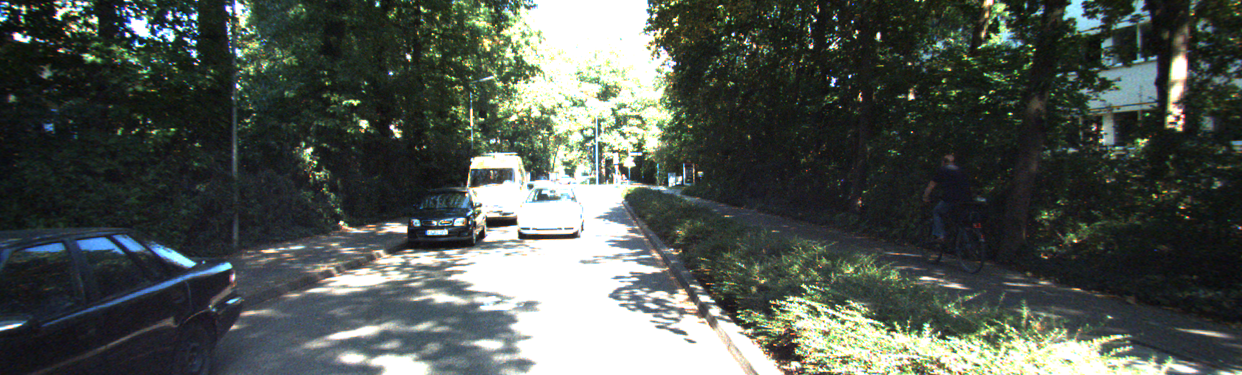

In [10]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img


이미지와 라벨을 얻는 방법을 알게 되었습니다.


![원본](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-4-P-input.max-800x600.png)  
<center>[KITTI 원본이미지 예시]</center>  

![bbos](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-4-P-sample.max-800x600.png)  
<center>[KITTI 이미지 바운딩 박스 시각화 예시]</center>   

이제 이미지 위에 바운딩 박스를 그려서 시각화를 할 것입니다. 



width: 1242  height: 375
(6, 4)
object_bbox[:,0]:  [0.00266667 0.34125334 0.39024    0.36549333 0.25906667 0.45048   ]
object_bbox[:,2]:  [0.43826666 0.50850666 0.58568    0.51453334 0.59816    0.5186933 ]
y_min:  [374.      247.03    228.65999 237.94    277.85    206.06999]
y_max:  [210.65    184.31    155.37    182.05    150.68999 180.49   ]
[  0.   374.   257.82 210.65]
[402.16 247.03 489.84 184.31]
[457.99    228.65999 530.41003 155.37   ]
[516.43 237.94 587.52 182.05]
[ 900.71     277.85    1004.13995  150.68999]
[520.27997 206.06999 550.59    180.49   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7FD02071F4D0>


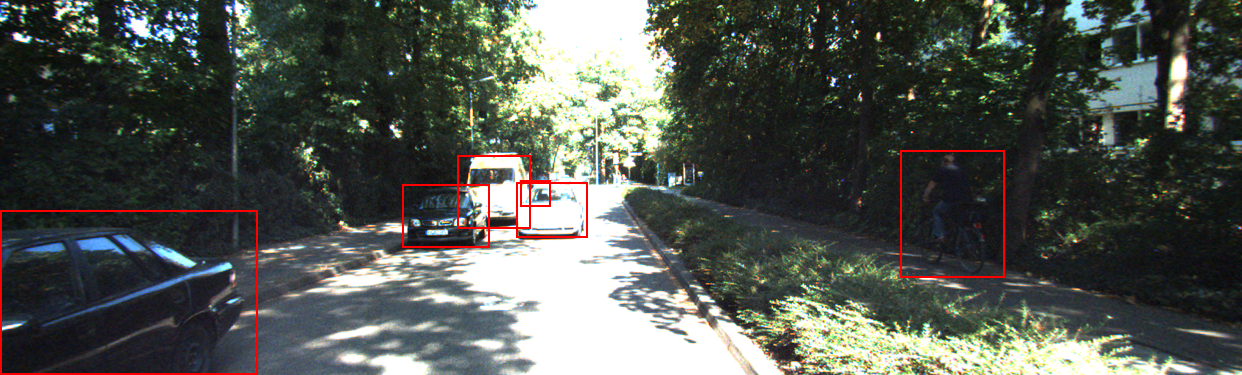

In [29]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    print('object_bbox[:,0]: ', object_bbox[:,0])
    print('object_bbox[:,2]: ', object_bbox[:,2])
    print('y_min: ', y_min)
    print('y_max: ', y_max)

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

# RetinaNet 논문 참고

  

RetinaNet은 *Focal Loss for Dense Object Detection* 논문을 통해 공개된 detection 모델입니다.

Detection 모델을 직접 만들기에는 많은 시간이 소요되므로, 미리 모델을 구현한 라이브러리를 가져와 커스텀 데이터셋에 학습시키고 빠르게 사용하겠습니다. 

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있었습니다.

이를 해결하기 위해서 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용합니다.  

![Retina](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-4-P-car.max-800x600.png)  


---

## Focal Loss

Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었습니다. 

위 그림 왼쪽 7x7 feature level에서는 한 픽셀이고, 오른쪽의 image level(자동차 사진)에서 보이는 그리드는 각 픽셀의 receptive field입니다.  

그림에서 보이는 것처럼 우리가 사용하는 이미지는 물체보다는 많은 배경을 학습하게 됩니다. 

논문에서는 이를 해결하기 위해서 Loss를 개선하여 정확도를 높였습니다.  

![focal loss](https://aiffelstaticprd.blob.core.windows.net/media/original_images/focal_loss.png)  

Focal loss는 우리가 많이 사용해왔던 교차 엔트로피를 기반으로 만들어졌습니다. 

위 그림을 보면 Focal loss는 그저 교차 엔트로피 CE($p_t$)의 앞단에 간단히 $(1-p_t)^\gamma$라는 modulating factor를 붙여주었습니다.  

교차 엔트로피의 개형을 보면 ground truth class에 대한 확률이 높으면 잘 분류된 것으로 판단되므로 손실이 줄어드는 것을 볼 수 있습니다.

하지만 확률이 1에 매우 가깝지 않은 이상 상당히 큰 손실로 이어지게 돱니다. 그러면 모델 학습 시키는 과정에서 문제가 발생이 됩니다.  


따라서 이미지는 극단적으로 배경의 class가 많은 class imbalanced data라고 할 수 있습니다. 

이렇게 너무 많은 배경 class에 압도되지 않도록 modulating factor로 손실을 조절해줍니다. 

람다를 0으로 설정하면 modulating factor가 0이 되어 일반적인 교차 엔트로피가 되고 람다가 커질수록 modulating이 강하게 적용됩니다.

![4](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-4-P-fpn.max-800x600.png)  



---

## FPN(Feature Pyramid Network)

FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식입니다.

CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용할 수 있습니다. 

이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약해 내기 때문에, 입력 이미지를 기준으로 생각하면 입력 이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 "셀(cell)"이 넓은 이미지 영역의 정보를 담고 있고, 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 범위의 정보를 담고 있습니다.

이를 receptive field라고 합니다. 레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 갖게 되는 것입니다.  

SSD가 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식을 취했다면 RetinaNet에서는 receptive field가 넓은 뒷쪽의 특성 맵을 upsampling(확대)하여 앞단의 특성 맵과 더해서 사용했습니다.

레이어가 깊어질수록 feature map의 $w,h$방향의 receptive field가 넓어지는 것인데, 넓게 보는 것과 좁게 보는 것을 같이 쓰겠다는 목적입니다. 

  

![d](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-3-P-FPN.max-800x600.png)  


##  데이터 포맷 변경

![실습](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-4-P-keras_retinanet.max-800x600.png)  


사실 `tensorflow_dataset`의 KITTI 데이터셋을 그대로 사용해서 Keras RetinaNet을 학습시키기 위해서는 라이브러리를 수정해야 합니다. 

하지만 이보다 더 쉬운 방법은 해당 모델을 훈련할 수 있는 공통된 데이터셋 포맷인 CSV 형태로 모델을 변경해주는 방법입니다. 


## 클래스 및 바운딩 박스 정보 추출


`tensorflow_dataset`의 API를 사용해 이미지와 각 이미지에 해당하는 바운딩 박스 라벨의 정보를 얻을 수 있었습니다. 그렇다면 API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장해 봅시다.  

한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 작성하도록 코드를 작성하고, 이를 사용해 CSV 파일을 생성합니다.

In [17]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [14:05<00:00,  7.51it/s]


테스트 데이터셋에 대해서도 동일하게 
parse_dataset() 을 적용해서 dataframe을 생성해 봅시다.

In [18]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:39<00:00,  7.18it/s]




## 클래스 맵핑

데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 합니다.

이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 

학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있습니다.  

아래 형식을 참고하여, 자동차와 사람을 구별하기 위한 클래스 맵핑 함수를 만들어 주세요.  

    class_name,id

    #Example
    cow,0
    cat,1
    bird,2

In [19]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

##  셋팅

학습이 잘 되기 위해서는 환경에 따라 `batch_size`나 `worker`, `epoch`를 조절해야 합니다.  

훈련 이미지 크기 또는 `batch_size`가 너무 크면 GPU에서 out-of-memory 에러가 날 수 있으니 적절히 조정해야 합니다.


In [20]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-13 15:22:25.306972: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 15:22:27.620055: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-13 15:22:27.623255: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-13 15:22:27.652190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-13 15:22:27.652589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-13 15:22:27.652609: I tensorflow/stream_executor/platform/default/d

아래 코드를 사용해 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환합니다.

In [21]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-13 16:14:52.364907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 16:14:54.332637: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-13 16:14:54.336030: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-13 16:14:54.343749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-13 16:14:54.344188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-13 16:14:54.344216: I tensorflow/stream_executor/platform/default/d

## 시각화
이제 위에서 변환한 모델을 load하고 추론 및 시각화를 해보세요!  

아래에 load된 모델을 통해 추론을 하고 시각화를 하는 함수를 작성해 주세요. 일정 점수 이하는 경우를 제거해야 함을 기억해야 합니다.

 



![e](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-4-P-inferenced.max-800x600.png)  
<center> [예시 이미지]</center>  

![ee](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-4-P-inferenced_1.max-800x600.png)  
<center>[예시 이미지]</center>

In [24]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.getenv('HOME') + '/aiffel/object_detection/snapshots/resnet50_csv_50_infer.h5'
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[592.82825 175.8489  625.3645  206.03694]


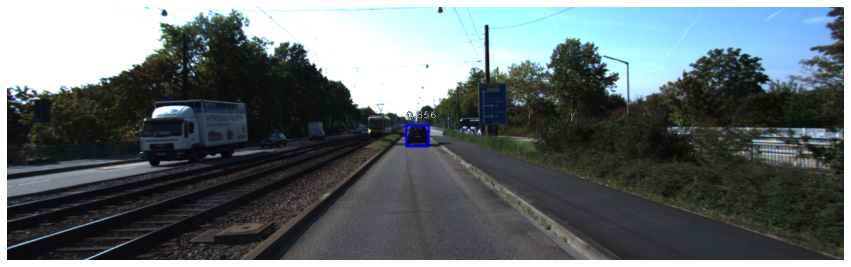

In [105]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):   
            if score < 0.5:
                break
            print(box)
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[772.3383 142.8007 844.0557 316.6772]


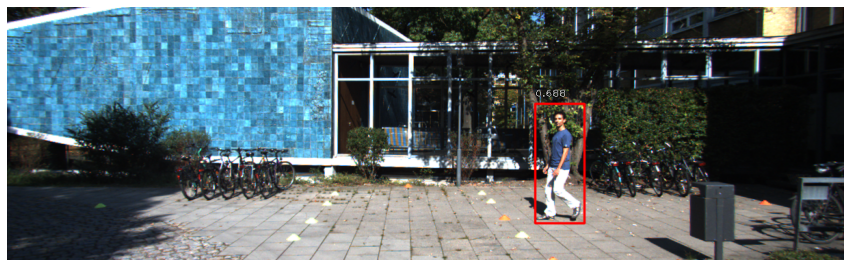

In [98]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)